#COVID-19 Outbreak Analysis

---

####Source Code



In [47]:
# data
!git clone https://github.com/CSSEGISandData/COVID-19.git

!pip install geocoder

import pandas as pd  
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime 
import geocoder
import folium
from folium import plugins 

# DataFrame for the world
conf_csv = '/content/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
conf_df = pd.read_csv(conf_csv)
grouped_conf_df = conf_df.groupby(by = ['Country/Region'], as_index = False).sum()

# DataFrame for India
india_df = pd.read_csv("https://api.covid19india.org/csv/latest/state_wise.csv")
india_df = india_df.iloc[1:36, :]
state_latitudes = []
state_longitudes = []
for i in india_df.index:
    state = india_df['State'][i]
    state_lat = geocoder.osm(state).lat
    state_lng = geocoder.osm(state).lng
    state_latitudes.append(state_lat)
    state_longitudes.append(state_lng)

state_latitudes = pd.Series(data = state_latitudes, index = india_df.index)
state_longitudes = pd.Series(data = state_longitudes, index = india_df.index)
india_df['Latitude'] = state_latitudes
india_df['Longitude'] = state_longitudes
india_df = india_df[india_df['State'] != 'State Unassigned']

# state_coordinates = [(19.7515, 75.7139), # Maharashtra
#                     (11.1271, 78.6569), # Tamil Nadu
#                     (15.9129, 79.7400), # Andhra Pradesh
#                     (15.317, 75.7139), # Karnataka
#                     (28.7041, 77.1025), # Delhi
#                     (26.8467, 80.9462), # UP
#                     (22.9868, 87.8550), # WB
#                     (25.0961, 85.3131), # Bihar
#                     (18.1124, 79.0193), # Telangana
#                     (22.2587, 71.1924), # Gujarat
#                     (26.2006, 92.9376), # Assam
#                     (27.0238, 74.2179), # Rajasthan
#                     (20.9517, 85.0985), # Odisha
#                     (29.0588, 76.0856), # Haryana
#                     (22.9734, 78.6569), # Madhya Pradesh
#                     (10.8505, 76.2711), # Kerala
#                     (31.1471, 75.3412), # Punjab
#                     (33.7782, 76.5762), # Jammu and Kashmir
#                     (23.6102, 85.2799), # Jharkhand
#                     (21.2787, 81.8661), # Chattisgarh
#                     (30.0668, 79.0193), # Uttarakhand
#                     (15.2993, 74.1240), # Goa
#                     (23.9408, 91.9882), # Tripura
#                     (11.9416, 79.8083), # Puducherry
#                     (24.6637, 93.9063), # Manipur
#                     (31.1048, 77.1734), # Himachal Pradesh
#                     (26.1584, 94.5624), # Nagaland
#                     (28.2180, 94.7278), # Arunachal Pradesh
#                     (11.7401, 92.6586), # Andaman and Nicobar
#                     (34.1700, 77.5800), # Ladakh
#                     (30.7333, 76.7794), # Chandigarh
#                     (20.1809, 73.0169), # Dadra and Nagar Haveli
#                     (25.4670, 91.3662), # Meghalaya
#                     (27.5330, 88.5122), # Sikkim
#                     (23.1645, 92.9376), # Mizoram
#                      ]
                  
# ind_state_lat = pd.Series([s[0] for s in state_coordinates], index = india_df.index)
# ind_state_lng = pd.Series([s[1] for s in state_coordinates], index = india_df.index)

# india_df['Latitude'] = ind_state_lat
# india_df['Longitude'] = ind_state_lng

# DataFrame for the US
us_conf_csv = '/content/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
us_conf_df = pd.read_csv(us_conf_csv)
us_conf_df = us_conf_df.dropna()
grouped_us_conf_df = us_conf_df.groupby(by = ['Combined_Key'], as_index = False).sum()

# Function to get total confirmed cases in a country
def get_total_confirmed_cases_for_country(country_name):
    total_cases_country = conf_df[conf_df['Country/Region'] == country_name].iloc[:, 4:].apply(sum, axis = 0)
    total_cases_country.index = pd.to_datetime(total_cases_country.index)
    return total_cases_country

# Function to get total confirmed cases in the world
def get_total_confirmed_global_cases():
    global_cases = conf_df.iloc[:, 4:].apply(sum, axis=0)
    global_cases.index = pd.to_datetime(global_cases.index)
    return global_cases

# Function to create a line plot
def line_plot(your_name, plot_background, fig_width, fig_height, country_name, colour, linewidth, markertype):
    dt_series = None
    if country_name != 'global':
        dt_series = get_total_confirmed_cases_for_country(country_name)
    else:
        dt_series = get_total_confirmed_global_cases()
    plt.style.use(plot_background)
    plt.figure(figsize = (fig_width, fig_height))
    plt.title(f'{country_name.upper()}: Total Coronavirus Cases Reported\nCreated by {your_name.upper()}\n', fontsize = 16)
    plt.plot(dt_series.index, dt_series, c = colour, lw = linewidth, marker = markertype, markersize = 7)
    plt.xticks(rotation = 45)
    plt.ylabel("Total Cases")
    plt.grid(linestyle='--', c='grey')
    plt.show()

# Add minimap
def add_minimap(map_name):
    # Plugin for mini map
    minimap = plugins.MiniMap(toggle_display = True)
    map_name.add_child(minimap) # Add minimap
    plugins.ScrollZoomToggler().add_to(map_name) # Add scroll zoom toggler to map
    plugins.Fullscreen(position='topright').add_to(map_name) # Add full screen button to map

# Add title to map
def add_title(map_name, country, your_name):
    title_html = '''
        <h2 align="center" style="font-size:20px"><b>Coronavirus Total Confirmed Cases in {}</b></h2>
        <h4 align="center" style="font-size:16px"><i>Created by</i> {}</h4>
      
             '''.format(country, your_name.upper())   
    return map_name.get_root().html.add_child(folium.Element(title_html))

# Function to create folium maps using for India, US and the world
def folium_map_with_circles(your_name, country, map_width, map_height, left_margin, top_margin, map_tile, zoom, circle_color, minimap):
    last_col = conf_df.columns[-1]
    if country == 'India':
        india_map = folium.Map(location = [22.3511148, 78.6677428], 
                               width = map_width, height = map_height,
                               left = f"{left_margin}%", top = f"{top_margin}%",
                               tiles = map_tile, zoom_start = zoom)
        
        if minimap == True:
            add_minimap(india_map)
        
        add_title(india_map, country, your_name)
        for i in india_df.index:
            folium.Circle(radius = float(india_df.loc[i, 'Confirmed']) / 25,
                          location = [india_df.loc[i, 'Latitude'], india_df.loc[i, 'Longitude']],
                          popup = "{}\n {}\n on {}".format(india_df.loc[i, 'State'], 
                                                          india_df.loc[i, 'Confirmed'], 
                                                          india_df.loc[i, 'Last_Updated_Time']),
                          
                          color = circle_color,
                          fill = True).add_to(india_map)
        return india_map

    elif country == 'US':
        us_map = folium.Map(location = [39.381266, -97.922211], 
                            width = map_width, height = map_height, 
                            left = f"{left_margin}%", top = f"{top_margin}%",
                            tiles = map_tile, zoom_start = zoom)
        if minimap == True:
            add_minimap(us_map)
        
        add_title(us_map, country, your_name)
        for i in grouped_us_conf_df.index:
            folium.Circle(location = [grouped_us_conf_df.loc[i, 'Lat'], grouped_us_conf_df.loc[i, 'Long_']], 
                          radius = int(grouped_us_conf_df.loc[i, last_col]) / 25, 
                          popup = "{}\n {}\n on {}".format(grouped_us_conf_df.loc[i, 'Combined_Key'],
                                                          grouped_us_conf_df.loc[i, last_col],
                                                          last_col),
                          color = circle_color,
                          fill = True).add_to(us_map)
        return us_map
    
    elif country == 'World':
        world_map = folium.Map(location = [0, 0], 
                            width = map_width, height = map_height, 
                            left = f"{left_margin}%", top = f"{top_margin}%",
                            tiles = map_tile, zoom_start = zoom)
        if minimap == True:
            add_minimap(world_map)
        
        add_title(world_map, country, your_name)
        for i in grouped_conf_df.index:
            folium.Circle(location = [grouped_conf_df.loc[i, 'Lat'], grouped_conf_df.loc[i, 'Long']], 
                          radius = int(grouped_conf_df.loc[i, last_col]) / 50, 
                          popup = "{}\n {}\n on {}".format(grouped_conf_df.loc[i, 'Country/Region'],
                                                          grouped_conf_df.loc[i, last_col], 
                                                          last_col),
                          color = circle_color, 
                          fill = True).add_to(world_map)
        return world_map
    else:
        print("\nWrong input! Enter either India, US or World.\n")

# Total confirmed cases in the descending order.
grouped_conf_df = conf_df.groupby(by='Country/Region', as_index=False).sum()
desc_grp_conf_df = grouped_conf_df.sort_values(by=conf_df.columns[-1], ascending=False)

# Function to create a bar plot displaying the top 10 countries having the most number of coronavirus confirmed cases.
def bar_plot(your_name, num_countries, width, height):
    last_col = conf_df.columns[-1]
    latest_date = datetime.datetime.strptime(last_col, '%m/%d/%y').strftime('%B %d, %Y') # Modify the latest date in the 'Month DD, YYYY' format.
    plt.figure(figsize = (width, height))
    plt.title(f'Top {num_countries} Countries with Highest COVID-19 Confirmed Cases\nCreated by {your_name.upper()}\n', 
              fontsize = 16)
    sns.barplot(desc_grp_conf_df[last_col].head(num_countries), desc_grp_conf_df['Country/Region'].head(num_countries), orient = 'h')
    plt.xlabel(f'Total Confirmed Cases (in millions) as of {latest_date}')
    plt.show()

# Non-cumulative Confirmed Cases.
non_cum_conf_df = desc_grp_conf_df.iloc[:, :4]
for i in range(len(desc_grp_conf_df.columns[3:]) - 1):
    series = desc_grp_conf_df[desc_grp_conf_df.columns[3 + (i + 1) ]] - desc_grp_conf_df[desc_grp_conf_df.columns[3 + i]]
    non_cum_conf_df[desc_grp_conf_df.columns[3 + (i + 1)]] = series

# Function to get the total non-cumulative confirmed cases in a country.
def get_total_daily_confirmed_cases_for_country(country_name):
    total_daily_cases = non_cum_conf_df[non_cum_conf_df['Country/Region'] == country_name].iloc[:, 4:].apply(sum, axis = 0)
    total_daily_cases.index = pd.to_datetime(total_daily_cases.index)
    return total_daily_cases

# Line plot for the daily (non-cumulative) confirmed cases in various countries.
def daily_cases_line_plot(your_name, num_countries, width, height):
    plt.figure(figsize=(width, height))
    plt.title(f'Non-Cumulative COVID-19 Confirmed Cases\nCreated by {your_name.upper()}\n', fontsize = 16)
    for region in non_cum_conf_df.iloc[:num_countries, :]['Country/Region']:
        total_conf_cases = get_total_daily_confirmed_cases_for_country(region)
        plt.plot(total_conf_cases.index[53:], total_conf_cases[53:], lw=2.5, label=region)
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid('major', linestyle='--', c='grey')
    plt.show()

fatal: destination path 'COVID-19' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:214: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


---

#### Line Plot



In [48]:
conf_df[conf_df['Country/Region'] == 'India']

Province/State Country/Region        Lat      Long  1/22/20  1/23/20  \
148            NaN          India  20.593684  78.96288        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...   10/7/22   10/8/22   10/9/22  \
148        0        0        0        0  ...  44609257  44612013  44614437   

     10/10/22  10/11/22  10/12/22  10/13/22  10/14/22  10/15/22  10/16/22  
148  44616394  44616235  44621319  44623997  44626427  44628828  44630888  

[1 rows x 1003 columns]

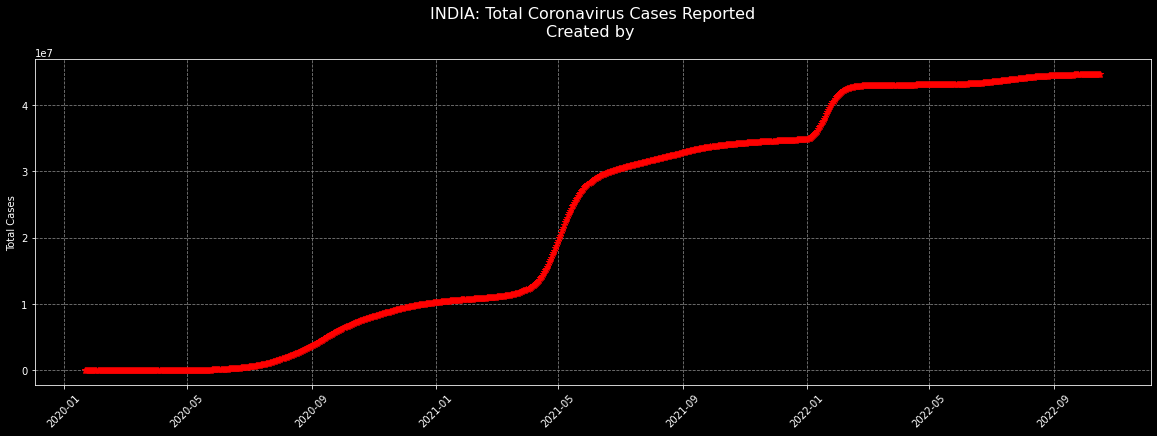

In [49]:
line_plot('', 'dark_background', 20, 6, 'India', 'red', 2, '*')

---

####Map



In [50]:
india_df.head()

State  Confirmed  Recovered  Deaths  Active  \
1  Andaman and Nicobar Islands       7651       7518     129       4   
2               Andhra Pradesh    2066450    2047722   14373    4355   
3            Arunachal Pradesh      55155      54774     280     101   
4                        Assam     610645     600974    5997    2327   
5                        Bihar     726098     716390    9661      46   

     Last_Updated_Time  Migrated_Other State_code  Delta_Confirmed  \
1  13/08/2021 23:27:22               0         AN                0   
2  13/08/2021 23:27:22               0         AP                0   
3  13/08/2021 23:27:22               0         AR                0   
4  13/08/2021 23:27:22            1347         AS                0   
5  13/08/2021 23:27:22               1         BR                0   

   Delta_Recovered  Delta_Deaths  \
1                0             0   
2                0             0   
3                0             0   
4                0             0   
5                0             0   

                                         State_Notes   Latitude  Longitude  
1                                                NaN  12.611239  92.831654  
2                                                NaN  15.924091  80.186381  
3  [July 25]: All numbers corresponding to Papum ...  28.093770  94.592133  
4  [Jan 1]: 1347 cases i.e Covid +'tive patients ...  26.407384  93.255130  
5  [June 9] : 3951 deceased cases have been repor...  25.644085  85.906508

In [51]:
folium_map_with_circles('', 'India', 800, 500, 8, 2, 'Stamen Terrain', 4, 'red', False)

In [52]:
india_map = folium_map_with_circles('', 'India', 1200, 500, 8, 2, 'Stamen Terrain', 4, 'red', True)
india_map.save('/content/index.html') 

---

####Bar Plot



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


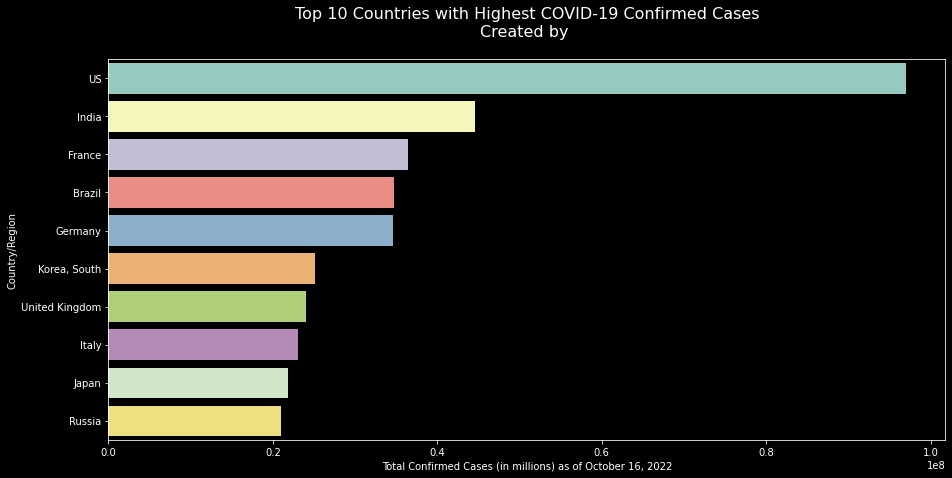

In [53]:
bar_plot('', 10, 15, 7)

---

####Daily (Non-Cumulative) Confirmed Cases Line Plot


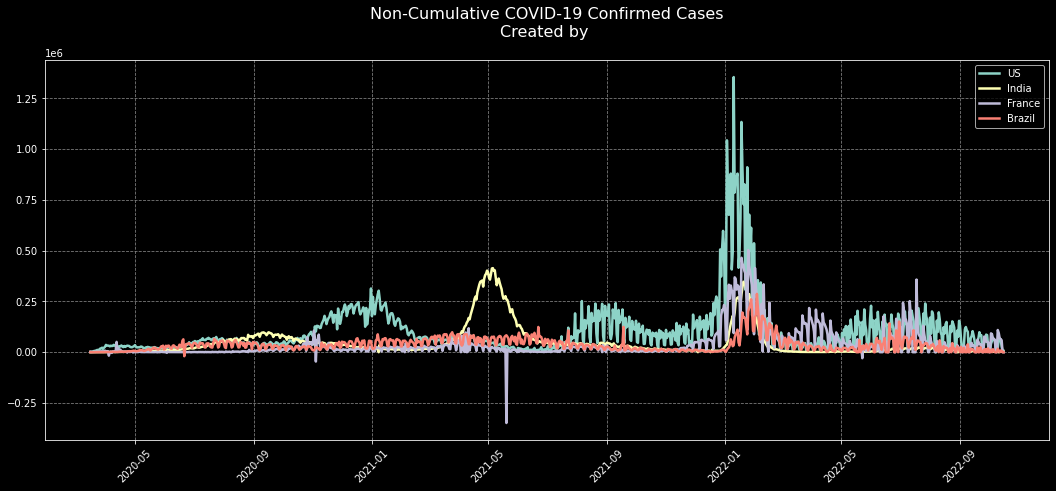

In [54]:
daily_cases_line_plot('', 4, 18, 7)

---

####Map for the USA

In [55]:
folium_map_with_circles('', 'US', 1200, 500, 8, 2, 'OpenStreetMap', 4, 'magenta', True)

In [56]:
us_map = folium_map_with_circles('', 'US', 1200, 500, 8, 2, 'OpenStreetMap', 4, 'magenta', True)
us_map.save('/content/usmap.html')

---

####Map for the World

In [57]:
folium_map_with_circles('', 'World', 1200, 500, 8, 2, 'OpenStreetMap', 2, 'red', True)

In [58]:
world_map = folium_map_with_circles('', 'World', 1200, 500, 8, 2, 'OpenStreetMap', 2, 'red', True)
world_map.save('/content/worldmap.html')

---